# Practical 1: Keyword spotting for microcontrollers

**IMPORTANT**: Save a copy of this notebook in your Drive by clicking "_File->Save a copy in Drive_" and do the work using your copy.

Usage: To train your neural networks using GPU acceleration, make sure that the runtime type is set to GPU in the _Runtime_->_Change runtime type_ menu. Further, you will see "cells" with code, which you can run either by using Ctrl+Enter or by clicking the play button in their top left corner. If you're not familiar with Google Colab or Jupyter Notebooks, you can check a tutorial video [here](https://www.youtube.com/watch?v=inN8seMm7UI):

## Introduction

Small computational devices, such as microcontrollers, are often used in IoT type devices where we need some but not too much computational ability, like a smart doorbell, a remote control, an Apple Pencil (!), to name a few. They are extremely power efficient, but also heavily resource-constrained: "high-end" microcontrollers will have up to 2 MB of storage, 1 MB of RAM and a ~400 MHz simple single-core ARM processor. Much worse than your average smartphone!

We can make devices powered by microcontroller units (MCUs) more smart by running some very small neural networks on them. In this practical, we'll focus on keyword spotting (KWS), that is recognising spoken words, such as "Alexa" or "OK Google". Often in these systems, microcontroller-driven KWS is just the first step in the recognition pipeline. Once a light model, running on an MCU, spots what could be an activation word, it will enable better microphones, use a larger model and a more powerful processor to do the rest of the recognition.

Progression of the practical:
1. Training a model to recognise a keyword from a predefined set of keywords. This is done using convolutional networks trained on audio recordings that are converted to spectrograms.
2. Converting a TensorFlow/Keras model into a TFLite format suitable for deployment on a constrained device. This will optimise the model (its computation graph) and quantize the parameters (more on that later).
3. Deploying your model onto a microcontroller to see how it runs!

## Training a keyword spotting model

Let's set up the runtime. You can see the files being created by clicking the folder icon (Files sidebar) on the left hand side. The first 2 cells will take a while to run (setting up TensorFlow, downloading the dataset), so start them early. If you get disconnected from the machine, you will have to re-run these cells.

In [5]:
# Only need to run this cell once per machine you get allocated (i.e. when your files get lost).
# No need to re-run between different runtime refreshes.
%pip uninstall -y tensorflow tensorflow-estimator tensorboard
%pip install tensorflow==2.8.0
%curl https://raw.githubusercontent.com/eliberis/mcu-deployment-tutorial/master/speech_dataset.py > speech_dataset.py

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.8.0
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%curl` not found.


We will use the [Speech Commands](https://arxiv.org/abs/1804.03209) dataset which contains thousands of recordings of short words, such as "Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", etc. (see the linked paper for the full list, or open the "speech_dataset" folder in the Files sidebar once it has finished downloading).  

In [4]:
import tensorflow as tf
print("Using TensorFlow version", tf.__version__)

%rm -rf speech_dataset

from speech_dataset import SpeechDataset
dataset = SpeechDataset(words=["yes", "no"], silence_percentage=50, unknown_percentage=50)
batch_size = 128
train_data = dataset.training_dataset().batch(batch_size).prefetch(1) # .prefetch(1) preloads a batch onto a GPU
valid_data = dataset.validation_dataset().batch(batch_size).prefetch(1)

ModuleNotFoundError: No module named 'tensorflow'

In the code above, we create a dataset with words "yes" and "no". The system will also add samples for 2 more classes, "*silence*" and "*unknown*", which will help the model to learn to better pick out target words from the noise. The amount of extra samples can be controlled with `silence_percentage=` and `unknown_percentage=` parameters (e.g. `silence_percentage=25`) to `SpeechDataset` (press Ctrl+Space for autocompletion to see all available parameters).

Let's take a look at an example input:

In [1]:
import IPython.display as ipd
example = ipd.Audio('speech_dataset/no/012c8314_nohash_0.wav')
example


ValueError: rate must be specified when data is a numpy array or list of audio samples.

The `SpeechDataset` class converts audio files into [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) inputs. Spectrograms can be treated as 2D images (frequency power vs time plot), which means we can use a convolutional neural network (CNN) for this classification problem. To see what the data looks like, let's visualise a few input spectrograms and labels (different every time you run!):

In [ ]:
import matplotlib.pyplot as plt
for spectrogram, label in dataset.testing_dataset().shuffle(50).take(5):
    spectrogram, label = spectrogram.numpy(), label.numpy()  # convert from Tensors to ndarrays
    print("Word:", dataset.look_up_word(label))
    plt.imshow(spectrogram[:, :, 0].T / 26.0, vmin=0.0, vmax=1.0)  # normalise back to 0.0 to 1.0
    plt.show()
    print('Spectrogram shape:', spectrogram.shape)

Now, we set up and train a small model using the [Keras API](https://keras.io/guides/).

In [ ]:
import tensorflow as tf
input_shape = dataset.sample_shape()
num_classes = dataset.label_count()

# TODO: Flatten spectrogram, makes it compatible with EI
input_shape = spectrogram.shape[1:]

model = tf.keras.Sequential([
    # tf.keras.layers.Conv2D(8, (10, 8), strides=(2, 2), padding="SAME", activation="relu"),
    # Add flat buffer as input
    # tf.keras.layers.Conv1D(49 * 40),
    tf.keras.layers.Conv2D(8, (10, 8), strides=(2, 2), padding="SAME", activation="relu", input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Activation("softmax")
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(train_data, validation_data=valid_data, epochs=5)  # you'd want to train for more epochs!

Training can take a while, depending on the complexity of your model and the number of epochs. Now let's check its performance on the test dataset and save the trained model.


In [ ]:
test_data = dataset.testing_dataset().batch(64)
model.evaluate(test_data)
model.save("model.h5")

Download `model.h5` to your computer. From now on, if you lose connection to the runtime, you can resume work by uploading `model.h5` and using `model = tf.keras.models.load_model("model.h5")` to load the model instead of running the cell that trains the model from scratch.

### Testing with a custom recording

We can also test the model with a custom recording. The following will read the audio file and extract a spectrogram in a compatible way with the model (using the same parameters as the dataset preprocessing). Feel free to upload your own recordings in WAV format in the _Files_ sidebar!

In [ ]:
%curl https://raw.githubusercontent.com/eliberis/mcu-deployment-tutorial/master/yes.wav > yes.wav

In [ ]:
import IPython.display as ipd
ipd.Audio('yes.wav')

In [ ]:
# You can look up the sample rate in your file's metadata
# using a media player (defaults to 16000). If your recording
# is not in the right file format, convert it to 16-bit PCM WAV first.
sample = dataset.load_sample("yes.wav", sample_rate=16000).numpy()
print("Loaded file shape is", sample.shape, "and the model expects", dataset.sample_shape())

Due to different recording lengths, the first dimension of your sample might have a different length to what the model expects. In real-life, we would apply the model in a sliding window fashion until it goes over the segment of the audio where the keyword is audible. For now, however, we'll manually cut out a section of the audio of the expected length. For this, let's look at the spectogram of the entire recording:

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(sample[:, :, 0].T, origin="lower")

As you see, we could start at `x=35` to capture the interesting portion of the audio:

In [ ]:
import numpy as np
import tensorflow as tf
start_pos = 35
end_pos = start_pos + dataset.sample_shape()[0]
predictions = model.predict(np.expand_dims(sample[start_pos:end_pos], axis=0))
print(predictions)
print("Predicted class:", dataset.look_up_word(predictions.argmax()))

## Converting the model for MCU deployment

We need to take a few extra steps to ensure our model is compatible with the microcontroller environment. You've been provided with a [NUCLEO-F767ZI](https://www.st.com/en/evaluation-tools/nucleo-f767zi.html) development board, which features an ARM Cortex-M7 processor, 2MB of Flash storage (persistent storage) and 512 KB of SRAM (dynamic memory).

This a rather large development board with a "generous" amount of resources. In practice, such chips would be smaller than a 5p coin and have less memory and storage.

### Model constraints and quantisation

We will use the TensorFlow Lite **Micro** (TFLM) runtime to run our model on a microcontroller unit (MCU). We will embed our model as a big binary blob within a program to be run by an MCU, and TFLM will read it to extract the model structure (layers) and parameters, and execute it with the supplied input.

The model has to fit within the resource constraints of an MCU:
1. Information about our model and its weights, together with the microcontroller operating system (mbed-OS) and the  TFLM, have to fit within the Flash memory, which is 2MB.
2. All information produced at runtime, i.e. activations of the network and memory allocated by TFLM & mbed-OS, would have to within the SRAM memory, capping it at 512 KB.

Luckily, we can reduce the memory usage of our neural network by employing *quantization*. During training, the desktop runtime uses 32-bit floating point numbers which occupy 4 bytes per element. We will quantize our model to use 8-bit integer parameters (see [affine quantization](https://arxiv.org/abs/1712.05877) if you're interested in technical details) that occupy 1 byte per element. Sometimes, microcontrollers don't have floating point computation support (though this one does), so integer quantisation becomes a necessity rather than just a space-saving measure.

Given both storage and RAM restrictions, this means that any model has to have fewer than 2 million weights and no more than 512K elements of activation data to run on an MCU. In practice, this number is much lower due to framework overheads, as explained above, so as a rule of thumb keep your model at < 1M parameters and < 400 K peak memory usage. We'll see later on how to measure the size of the model and its peak memory usage.

We'll convert the model from the Keras format (`model.h5`) to the TensorFlow Lite format (`model.tflite`) using the provided converter. In addition to simply changing the format and quantising the model, the converter performs model architecture optimisation, e.g. folding batch normalisation layers and element-wise operations into preceding linear operations. To determine how to quantize network activations, the converter has to have an idea of what input data might look like, and for that reason we provide the validation dataset as a _representative dataset_.

In [ ]:
import tensorflow as tf
import numpy as np

def representative_dataset_gen():
    for sample, _ in dataset.validation_dataset():
        yield [np.expand_dims(sample, axis=0)]

model = tf.keras.models.load_model("model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_quant_model)

[Optional] We can visualise the resulting model using a tool called [Netron](https://github.com/lutzroeder/netron/releases). You can explore the model parameters by clicking on each node and looking at converted weights and quantisation parameters.

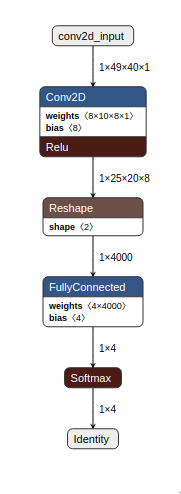

As mentioned earlier, any model to be run on an MCU should have sufficiently small peak memory usage. During the execution, the runtime only has to store tensors for the input and the output of an operator (layer) that it's currently executing. (However, [things can get more complicated for models with branches](https://arxiv.org/abs/1910.05110), like the Inception family.

We provide you with the `tflite-tools` toolkit to measure the peak memory usage.

In [ ]:
%pip install flatbuffers prettytable
%git clone https://github.com/eliberis/tflite-tools.git tflite_tools

In [ ]:
%python tflite_tools/tflite_tools.py -i model.tflite

**Keep the current peak memory usage value reported here below 400 KB**.

We can check if the quantisation affected the performance of our model (compare this with the accuracy measurement of the testing dataset we did earlier).

In [ ]:
import numpy as np

def evaluate(model_file, dataset):
    # Load the quantised TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()
    input_info = interpreter.get_input_details()[0]
    input_index = input_info["index"]
    scale, offset = input_info["quantization"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Push the dataset through the model and compute accuracy
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    test_data = dataset.batch(1).as_numpy_iterator()

    for x, y_true in test_data:
        # The model expects a quantised input, spanning the entire range of int8
        x = (x / scale - offset).astype(np.int8)
        interpreter.set_tensor(input_index, x)
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_index)
        accuracy.update_state(y_true, y_pred)
    return accuracy.result()

accuracy = evaluate("model.tflite", dataset.testing_dataset())
print(f"accuracy (quantised model) = {accuracy:.4f}")

### Model export

The following will export the model into a binary blob and also display its size.
You'll need to ensure it fits within the Flash memory, otherwise you'll get a _linker error_ when compiling your embedded program in later steps. However, if your activation matrices don't fit into the allowed memory buffer, the runtime will _silently corrupt the contents of memory_, making your program crash in unexpected ways.

In [ ]:
# !apt-get update  <-- run this if you get install errors
%apt-get -qq install xxd
%echo "Exporting model. Model size (in bytes):"
%stat --printf="%s" model.tflite
%xxd -i model.tflite > model.cc

Optionally, take a look at the contents of the blob. Download the `model.cc` file to your computer.

In [ ]:
%cat model.cc

# Running the model on an MCU

## Assembling the hardware

You should have: (a) the Nucleo-F767ZI board, (b) six jumper cables and (c) an SPH0645 I2S Microphone from [Adafruit](https://www.adafruit.com/product/3421) with headers soldered onto it.

1. Remove the jumper at JP6 (you can put it over some GND pins in the corners or on the back) and make sure jumpers on JP3 are set only to the middle one.

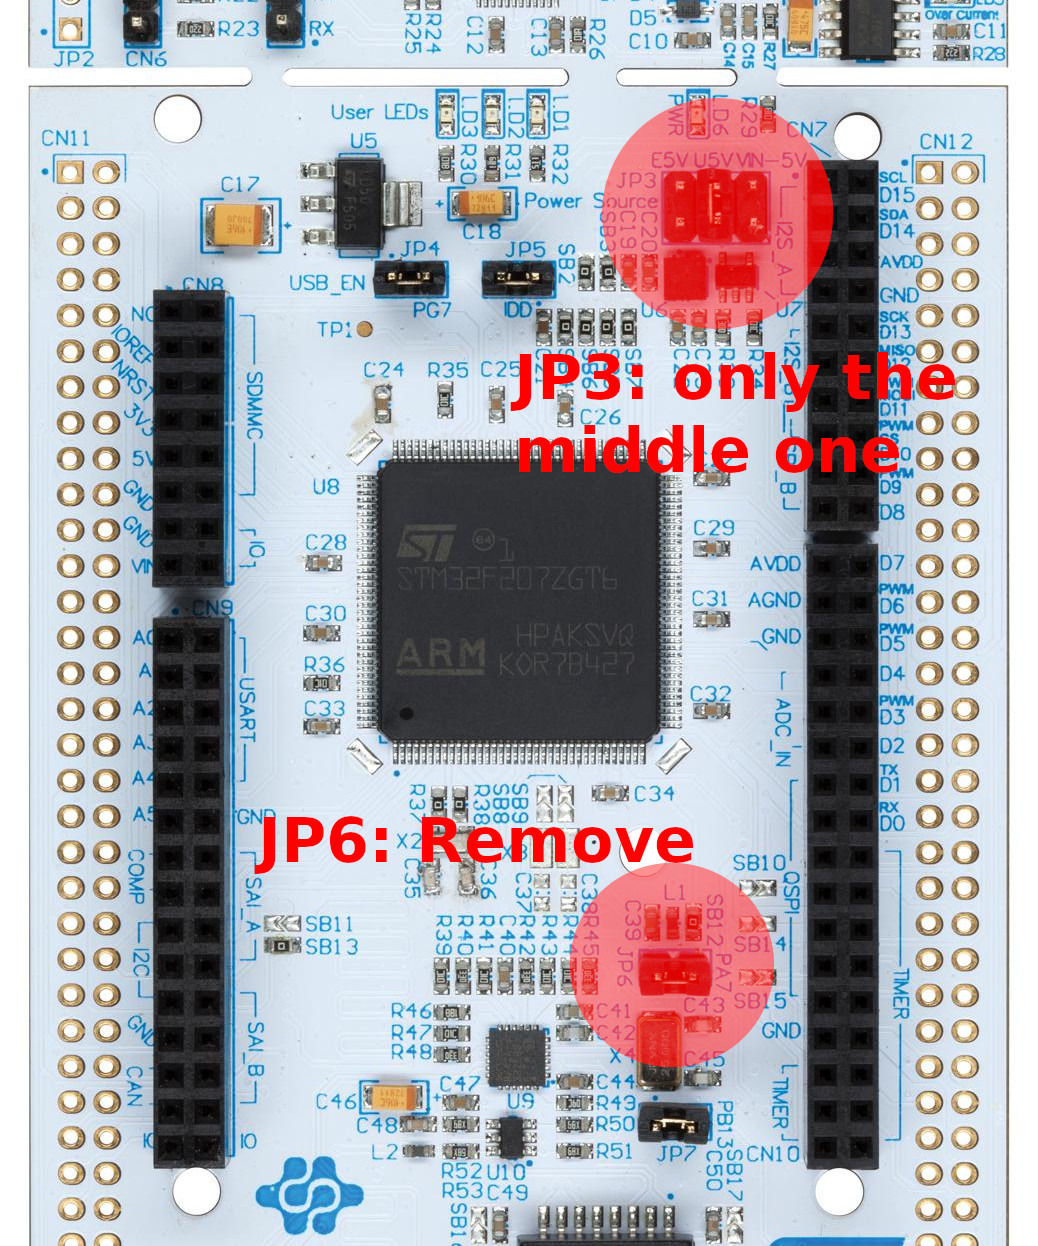

2. Connect the mic by pushing one end of each of six cables on each available pin on the microphone, and plug them into the board as follows. CN8 and CN7 refer to two black blocks with pin sockets on the left and right hand side of the board, respectively (you should be able to see the name written above the block). Pins are numbered left to right, top to bottom, starting at 1. A helpful diagram is also available below. Connect:

* SEL pin to pin #8 in CN7
* LRCL pin to pin #17 in CN7
* DOUT pin to pin #14 in CN7
* BCLK pin to pin #10 in CN7
* GND pin to pin #11 in CN8
* 3V pin to pin #7 in CN8 (should say 3V3 next to it)

3. Connect the USB cable to the **top** USB port on the board. Some people have issues connecting the board over USB hubs that don't supply enough power to the devices --- try a different (more expensive?) USB hub, or connect the board directly using a USB adapter.

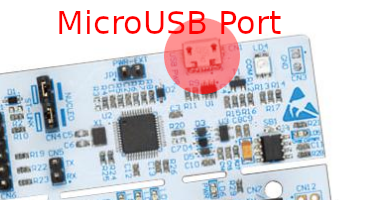

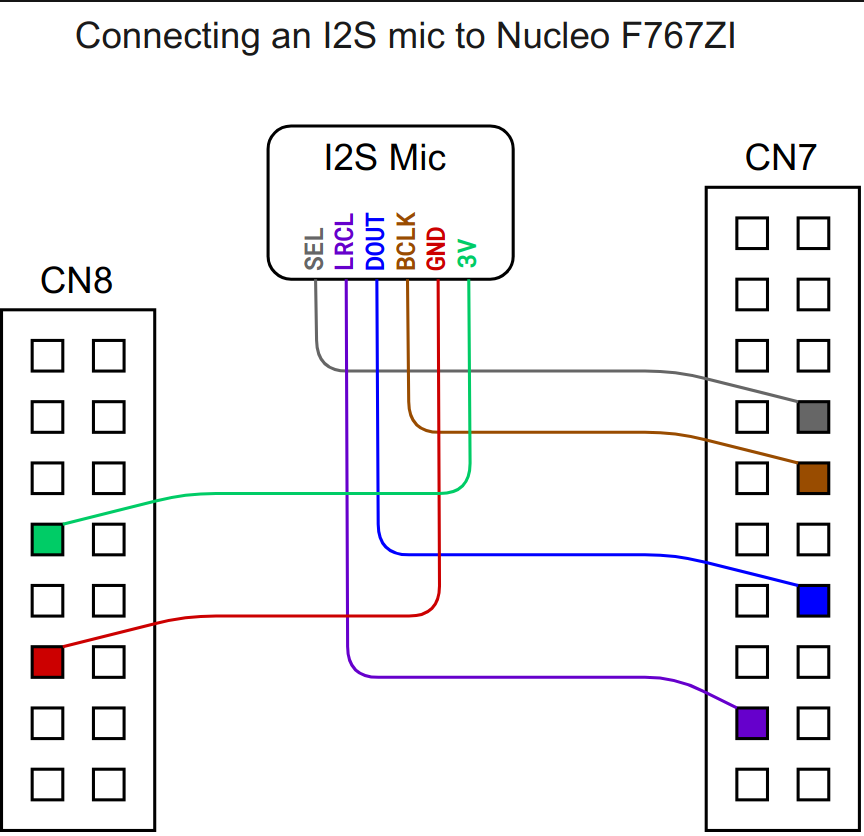

## Installing the development software on your computer

The board supports ARM's mbed development ecosystem, which makes compiling your code and flashing it onto the board fairly straightforward. The following assumes you will be using Mac OS or Linux as your operating system. If you're using Windows, you can either use a Linux virtual machine to complete the following steps, or try to set up [mbed-OS on Windows](https://os.mbed.com/docs/mbed-os/v6.3/quick-start/build-with-mbed-cli.html).

1. We'll need a Terminal with a working Python environment (either Python 2 or 3 should be fine). You can use either the system-wide or Anaconda Python (the one you get immediately by typing `python` in a new Terminal window), or [create a separate virtual environment](https://opensource.com/article/19/6/python-virtual-environments-mac).
2. Install the `mbed-cli` Python package: `pip install mbed-cli` (you might have to make it `sudo pip...` if you're using the default Python, or adjust commands accordingly if you're using `conda`).
3. Download the [GNU ARM Embedded Toolchain](https://developer.arm.com/tools-and-software/open-source-software/developer-tools/gnu-toolchain/gnu-rm/downloads) for your system. Extract it into any new folder. Don't extract it into the project directory that we're going to clone later (in case you read ahead). If you're using an OS with user package repositories (AUR on Arch Linux, `brew` on Mac OS), you can find an ARM Embedded Toolchain package there.

## Setting up the audio recognition project

Clone the project files:

`git clone https://github.com/eliberis/mcu-deployment-tutorial kws_model`

and navigate into the project directory:

`cd kws_model`

MCU will run an operating system called mbed-OS. Install extra mbed-OS requirements by typing

`pip install -r mbed-os/requirements.txt`

(If you get errors installing the `cryptography` package on Mac OS, see [this page](https://cryptography.io/en/latest/installation/#building-cryptography-on-macos))

Set up the toolchain using the following command. The toolchain is a set of compilers and other tools that will compile the software into a binary suitable for flashing onto an MCU. Make sure the extracted toolchain lies *outside* the source code you cloned in step 1:

`mbed config -G GCC_ARM_PATH <absolute_path_to_extracted_toolchain>/bin`

Note that the path MUST be the absolute path to the toolchain.

Connect your board via a USB cable and type:

`mbed compile -t GCC_ARM -m NUCLEO_F767ZI --flash`

After compilation ends, you can see what the board outputs into the terminal over the serial port by typing:

`mbed sterm` or `sudo screen /dev/tty.usbm<number>` (or `/dev/ttyACM<number>` on Linux, you can use autocomplete to figure out the number)

(press Ctrl-C to exit from `sterm` or `Ctrl+A` then `Ctrl-D` to exit from `screen`)

You can now modify files in the `kws_model` directory and compile and flash them onto the board using the `mbed compile...` command above.

## Using the keyword recognition model

The software running on the board listens for microphone input, then runs the keyword recognition model and prints its detections over the serial port (into the terminal). To restart the board and start a new round of keyword recognition, press the black button in the bottom-right corner. If your board only outputs "silence", try speaking louder.

The board indicates its status using the three LEDs in the "User LEDs" section.
* LED1 (green) indicates the software is being set up (the model is being loaded, etc.) --- should be very very brief.
* LED2 (blue) indicates the board is listening for input. This is set up to last 1.2s (the first 200ms are going to be discarded).
* LED3 (red) indicates that the keyword recognition model is running. The default network is quite small, so this should be very brief.

The system is only set up to listen once the blue LED2 is on.

## Swapping in a new model

Previously, we went through an entire model creation pipeline that produced a binary blob into `model.cc` with the contents of our model. To swap the default model with your new one, follow these steps:

1. Open the `model_data.cc` file from the `kws_model` folder and the downloaded `model.cc` file in your text editor.
2. Delete the contents of the `g_model_data` array in `model_data.cc`.
3. Copy the contents of the model array from the `model.cc` file and paste them into the now-empty `g_model_data` array. Make sure preserve the type of the `g_model_data` array: it should still say `const unsigned char g_model_data[] DATA_ALIGN_ATTRIBUTE = { ...`
4. Update `g_model_data_len` value at the bottom of `model_data.cc` with the length value you see at the bottom of the `model.cc` file. Again, make sure to preserve the type.
5. If you changed the number of outputs in the model by changing the word list:
  * update the category count in the `model_settings.h` file; it should be the number of words your model will recognise, plus 2.
  * update category labels in the `model_settings.cc` file: add strings for the new words you've added.
6. If you used a type of layer that this practical hasn't used so far and you get operation registration errors when trying to run your model, open the `audio_inference.cc` file and find the line that creates `tflite::MicroOpResolver<N>`. This pulls operator implementations into the software (at the cost of extra space, up to 2KB per operator). Follow the example there of how other layers were added and add a layer that you're missing (assuming it is available in TFLM). Change the `N` to the number of layers you're now registering. (You can also sacrifice a lot of space and pull in all layers by deleting lines relating to `micro_op_resolver` and changing the resolver type to `AllOpsResolver`.)

## Benchmarking the model

Now, we'd like to check how much time it takes to run the model on the board itself. One of the tasks below will ask you to modify the `main.cc` by adding a [Timer object](https://os.mbed.com/docs/mbed-os/v5.15/apis/timer.html) and printing its readings to the console.

Visit the linked documentation of the `Timer` class to see how to use it. Start your timer immediately before the line `infer();` in the `int main()` function, and stop it immediately afterwards. Instead of `printf(...)`, use `error_reporter->Report(...)` function to print the output to the console.

Interesting point: TensorFlow Lite Micro: (a) effectively interprets your model rather than executing it natively (a bit like a Java program running on your computer), (b) uses a very expressive but also expensive type of quantization (see "affine quantization" referenced earlier), and (c) may not have the best layer implementations for our particular microcontroller---all of which contributes to your model running slower than it potentially could. Thus, with extra engineering effort, it would actually be possible to make your model run faster.



# Tasks

The tasks and questions in the practicals for this course are split into two groups: A and B. We would like you to attempt tasks in just **one** of the groups, or both if you find yourself enjoying the material.

* Group A: playing with neural network design and compression; does not require deploying a model to an MCU;
* Group B: deploying a model onto an MCU and benchmarking it.

### Group A

**A1.** Add one or more extra words when creating the `SpeechCommands` dataset and re-run the model training code above.
* What percentages for `silence` and `unknown` classes should you pick to obtain a balanced dataset* overall?
(*balanced s.t. these 2 classes occupy a proportionate fraction with the respect to word classes; this does not guarantee that the word classes will be balanced with respect to each other: e.g. "yes" may contain more samples than "no").
* Does the accuracy of the model change depending on the words (and the number of words) you choose to include? If so, what do you think could be the factors influencing the change?

**A2.** Create a larger model that recognises the following words:

`['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']`

You may also want to adjust the optimiser, learning rate, or use a different convolutional kernel sizes and strides for the time and frequency axes of the input. Feel free to experiment with batch normalisation, residual connections, and other common neural network architecture patterns. Aim for 90%+ validation accuracy.

**Q.** What is the classification accuracy? What is the size of the model? (check `model.summary()`).


**A3 (optional).** Compress it by doing one of the following:

* replace some of the deeper convolutional layers (if your model has any) with [depthwise-separable convolutions](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D),
* distilling it into a smaller model,
* implementing and using the [Octave Convolution](https://arxiv.org/abs/1904.05049),
* or use any other model compression method, or an implement another efficient architecture (or a layer arrangement)!

You do not need to convert your model into TensorFlow Lite format.

**Q.** Do you expect your implemented model to become faster or small (or both?) as a result of your changes? Discuss.

*Rough guidance for distillation:* Come up with a smaller student network. Train the larger teacher model and freeze it using `teacher_model.trainable = False`. Create a smaller student network. Now, create a new combined Keras model that runs both the teacher and the student in parallel on the same input and outputs the output of the student network. Add an auxiliary cross-entropy or KL-divergence loss between the teacher and student models' outputs (`teaching_loss`) that will work in addition to the regular dataset loss (for example using the `tf.keras.losses.CategoricalCrossentropy()` class and `combined_model.add_loss(teaching_loss, inputs=True)`. Also, feel free to look up how to implement distillation in Keras (or just bare TensorFlow) online, but bear in mind that some examples might be outdated.

*Rough guidance for octave convolution:* Implement it either [as a custom layer](https://www.tensorflow.org/guide/keras/custom_layers_and_models) and/or explicitly define the two paths using [the functional API](https://www.tensorflow.org/guide/keras/functional). Note: you may struggle to convert this to TFLite, because 2D-upsampling is not supported by default.

*Pointers to other architectures*: Skim through the [Hello Edge: Keyword Spotting on Microcontrollers](https://arxiv.org/abs/1711.07128) paper for inspiration or other papers that cite it.

*Note on other frameworks*: If you prefer, you can use another deep learning framework. You may find it useful to reuse the data input pipeline: use `for image_batch, labels in train_data.as_numpy_iterator()` to iterate through an epoch of data.


Group A answers: (type in your answers here)

### Group B
**B1:** Play around with the architecture of the model and the training parameters. You could try the following:

1. Using a fully-connected model (only `Flatten` and `Dense` layers, extra helpful layers like `BatchNormalization` and `Dropout` are also allowed).

2. A larger convolutional network than the one already given (e.g. try adding more `Conv2D` layers with different parameters and `BatchNormalization` layers between `Conv2D` and `Activation('relu')`).

3. Tuning the number of epochs, the optimizer and the learning rate at each epoch. Tip: You may find the [`tf.keras.callbacks.LearningRateScheduler`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback useful.

4. Skim through the [Hello Edge: Keyword Spotting on Microcontrollers](https://arxiv.org/abs/1711.07128) paper for inspiration.

Present **any two** neural networks that you've implemented. Make sure they fit within resource constraints of your device. What's the architecture of the network, the number of words it recognises, and its accuracy? Your models should be able to reach over 90% of accuracy.

**B2.** Benchmark your 2 models on the device as per instructions above. How long does the inference take? If you run into issues deploying your model onto an MCU, make sure you follow all steps in the "Swapping in a new model" section.

Group B answers: (type in your answers here)

(c) 2021 Edgar Liberis. Licence CC BY 4.0. Material adapted from [TensorFlow Lite Micro speech example](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/speech_commands) and TensorFlow tutorial on [post-training quantisation](https://www.tensorflow.org/lite/performance/post_training_quantization).